# Physics 494/594
## Linear Regression

In [1]:
# %load ./include/header.py
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('./include')
import ml4s
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('./include/notebook.mplstyle')
np.set_printoptions(linewidth=120)
ml4s._set_css_style('./include/bootstrap.css')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Last Time

### [Notebook Link: 03_Batch_Processing.ipynb](./03_Batch_Processing.ipynb)

- Explored linear algebra in `numpy` for batch processing of samples
- Saw massive speedups! Use array operations whenever possible

## Today
- Cost functions and formulating a machine learning task as an optimization problem
- Understand linear regression 
- Learn how linear regression can learn non-linear functions using feature maps


### Example: Steady-State One-Dimensional Heat Conduction

Fourier's law of heat conduction for a bar of constant cross-sectional area connected between two reservoirs in the steady-state limit gives a simple differential equation for the spatial dependence of the temperature $T$:

\begin{align}
\frac{d^2 T(x)}{d x^2} &= 0 \\
\frac{d T(x)}{dx} &= w \\
T(x) &= w x + b 
\end{align}

Load experimental data from `../data/rod_temperature.dat` using the very convenient `np.loadtxt()` function

In [2]:
!head ../data/rod_temperature.dat

# Experimental data for the temperature T along a metal rod of length 10 cm
# suspended between two constant temperature baths.
# Position (m)     Temperature (deg C)     Delta T (deg C)
0.01                 15.6                    4.6
0.02                 17.5                    6.0
0.03                 36.6                    8.1
0.04                 43.8                    3.9
0.05                 58.2                    4.4
0.06                 61.6                    8.5
0.07                 64.2                    3.9


In [3]:
x,T,ΔT = np.loadtxt('../data/rod_temperature.dat', unpack=True)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


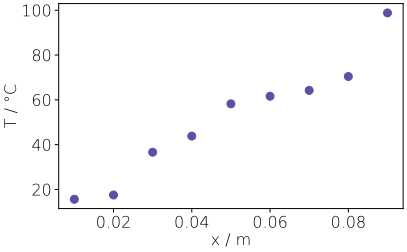

In [4]:
plt.plot(x,T, 'o')
plt.xlabel('x / m')
plt.ylabel('T / °C');

We expect a linear relationship, let's try to fit some lines by *eye*

Text(0.5, 1.0, 'Weight Space')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


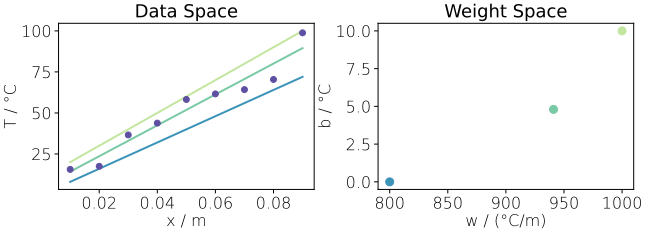

In [5]:
w = [800,941,1000]
b = [0,4.8,10]
x_fit = np.linspace(np.min(x),np.max(x),100)

fig,ax = plt.subplots(1,2, figsize=(10,3))
fig.subplots_adjust(wspace=0.25)
for i in range(len(w)):
    ax[0].plot(x_fit,w[i]*x_fit + b[i], color=colors[i+1])
    ax[1].plot(w[i],b[i], 'o', color=colors[i+1])
    
ax[0].plot(x,T, 'o', ms=6)
ax[0].set_xlabel('x / m')
ax[0].set_ylabel('T / °C')
ax[0].set_title('Data Space')

ax[1].set_xlabel('w / (°C/m)')
ax[1].set_ylabel('b / °C')
ax[1].set_title('Weight Space')

### Goal

Want to predict a scalar $T$ as a function of scalar $x$ given a dataset of pairs $\{(x^{(n)},T^{(n)})\}_{i=1}^N$.  Here the $x^{(n)}$ are inputs and the $T^{(n)}$ are targets or observations. From physics, we have a model:

\begin{equation}
F(x) = w x + b
\end{equation}

i.e. $F^{(n)} = w x^{(n)} + b$.

We can think of this as the simplest possible **shallow** neural network (no hidden layer) and non non-linearity, i.e. $f(x) = 1$.

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


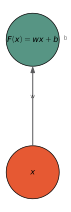

In [6]:
labels = [[r'$x$'],[r'$F(x) = wx + b$']]
ml4s.draw_network([1,1],node_labels=labels, weights=['w'], biases=['b'])

We want to *learn* the **parameters** (weight $w$ and bias $b$) based on the **prediction** $F$ (here a linear function).  We will do this by minimizing (optimizing) a **loss** function:

\begin{equation}
\mathcal{L} = \frac{1}{2} \lvert \lvert F - T \rvert \rvert^2
\end{equation}

which quantifies the goodness of fit over our **hypothesis** space (all values of the parameters).  $F-T$ is the residual, we want to make this as small as possible, which we can do by computing the **Cost** function, the loss function averaged over all training examples (input data):

\begin{equation}
\boxed{
\mathcal{C} = \frac{1}{2N} \sum_{n=1}^N  \lvert \lvert F^{(n)} - T^{(n)} \rvert \rvert^2
}
\end{equation}

Let's use what we learned last time about batch processing to look at this loss function. Here, our input samples are the individual values of $x$.

In [7]:
# for a specific hypothesis (i.e. individual values of w and b)
C_hyp = []
for i in range(len(w)):
    F = np.dot(x,w[i]) + b[i]
    C_hyp.append(0.5*np.average((F-T)**2))
print(C_hyp)

[94.48055555555555, 17.592138888888883, 51.92499999999998]


### Now we can do this over the entire space of weights and biases

In [8]:
grid_size = 100 
weights,biases = np.meshgrid(np.linspace(700,1200,grid_size),np.linspace(-1,11,grid_size))
C = np.zeros_like(weights)

for i in range(grid_size):
    for j in range(grid_size):
        F = np.dot(x,weights[i,j]) + biases[i,j]
        C[i,j] = 0.5*np.average((F-T)**2)

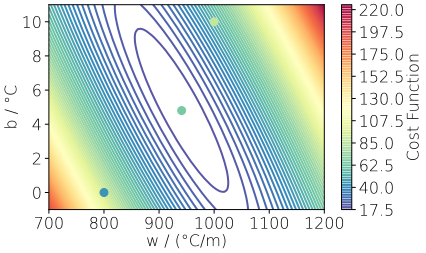

In [9]:
plt.contour(weights,biases,C, cmap='Spectral_r', levels=100)

for i in range(len(w)):
    plt.plot(w[i],b[i], 'o', color=colors[i+1])

plt.xlabel('w / (°C/m)')
plt.ylabel('b / °C')
plt.colorbar(label='Cost Function')

### Viewing in 3D

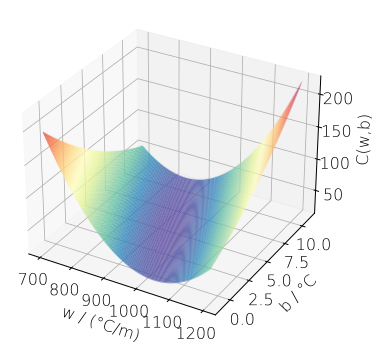

In [10]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8,6))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(weights, biases,C , rstride=1, cstride=1, cmap='Spectral_r', 
                       linewidth=0, antialiased=True, rasterized=True)
ax.set_xlabel('w / (°C/m)',labelpad=8)
ax.set_ylabel('b / °C',labelpad=8)
ax.set_zlabel('C(w,b)',labelpad=8);

### Moving beyond 1 dimension

Note that while we have looked at a simple 1D example, there is nothing stopping us from generalizing our model to an arbitrary number of  $D$ dimensions (i.e. think number of input neurons).  We don't even need to change our notation if we use matrix vector multiplication

\begin{align}
F &= \sum_j w_j x_j + b \\
&= \vec{w}^{\sf T} \vec{x} + b
\end{align}

where $\vec{w}^{\sf T} = (w_1,\dots, w_{D})$ and $\vec{x} = (x_1,\dots, x_{D})$.   Note that our code `np.dot(x,w)+b` doesn't even need to change!  

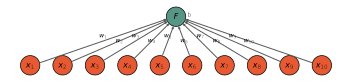

In [11]:
D = 10
N = [D,1]
labels = [[r'$x_{' + f'{i}' + r'}$' for i in range(1,N[0]+1)],[r'$F$']]
ml4s.draw_network(N,node_labels=labels, weights=[[r'$w_{' + f'{i}' + r'}$' for i in range(1,N[0]+1)]], biases=['b'])

Furthermore, we can perform the same batch processing as above, where now each **row** of $\mathbf{w}$ corresponds to a training example.

\begin{equation}
\mathbf{x} \cdot \mathbf{w} + b \mathbb{1} = \left(
\begin{array}{c}
\mathbf{w}^{\mathsf{T}} \cdot \mathbf{x}^{(1)} + b \\
\mathbf{w}^{\mathsf{T}} \cdot \mathbf{x}^{(2)} + b \\
\vdots \\
\mathbf{w}^{\mathsf{T}} \cdot \mathbf{x}^{(N)} + b
\end{array}\right) = 
\left(
\begin{array}{c}
F^{(1)} \\
F^{(2)} \\
\vdots \\
F^{(N)}
\end{array}
\right) = \vec{F}
\end{equation}

Here $\mathbb{1}$ is the identify matrix.  We can simplify our notation even further by noticing that we can incorporate the bias into the weight by tacking on a dummy input $x_0$ that always takes the value $1$ such that $w_0$ can be interpreted as the weight:

\begin{align}
\mathbf{X} &= (1,x_1,\dots, x_D)^{\mathsf{T}} \\
\mathbf{W} &= (b,w_1,\dots, w_D)^{\mathsf{T}}
\end{align}

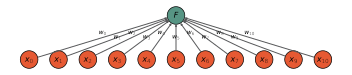

In [12]:
N = [D+1,1]
labels = [[r'$x_{' + f'{i}' + r'}$' for i in range(N[0])],[r'$F$']]
ml4s.draw_network(N,node_labels=labels, weights=[[r'$w_{' + f'{i}' + r'}$' for i in range(N[0])]], biases=[' '])

We can then compute the squared error cost across the entire data set:

\begin{align}
C &= \frac{1}{2N} \lvert\lvert \vec{F} - \vec{T}\rvert\rvert^2 \\
&= \frac{1}{2N} \lvert\lvert \mathbf{X} \cdot \mathbf{W} - \vec{T} \rvert\rvert^2
\end{align}

without modifying any of our python code.

## Solving the Optimization Problem

Recall, we are interested in finding the values of the weights and biases which minimize the cost function.  For the case of linear regression this can be done explicitly via calculus.

\begin{equation}
\frac{\partial C}{\partial w_j} = \frac{1}{N} \sum_{n=1}^{N}\left(F^{(n)} - T^{(n)} \right) x_j^{(n)} = \left \langle \left(F^{(n)} - T^{(n)} \right) x_j^{(n)} \right\rangle
\end{equation}

The minimum occurs when this equation is set to zero, which offers a convenient closed-form solution (you will derive this in the homework):

\begin{equation}
\mathbf{W} = \left(\mathbf{X}^{\sf T} \mathbf{X}\right)^{-1} \mathbf{X}^{\sf T} \vec{T}
\end{equation}

We can check this for our simple example of the rod temperature above.

In [13]:
X = np.zeros([len(x),2])
X[:,0] = 1
X[:,1] = x

In [14]:
W_opt = np.dot(np.dot(np.linalg.inv(np.dot(X.transpose(),X)),X.transpose()),T)
C_opt = 0.5*np.average((np.dot(X,W_opt)-T)**2)

print(f'W_opt = {W_opt}')
print(f'C_opt = {C_opt}')

W_opt = [  4.81388889 940.83333333]
C_opt = 17.592114197530865


This can be compared with the `np.polyfit` package

In [15]:
np.polyfit(x,T,1)

array([940.83333333,   4.81388889])

They have chosen to pack their extra dimension at the end! We can also compare the cost with a global optimization of the cost function computed above.

In [16]:
np.min(C)

17.59365625956535

##  Let's plot the optimal linear regression:

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


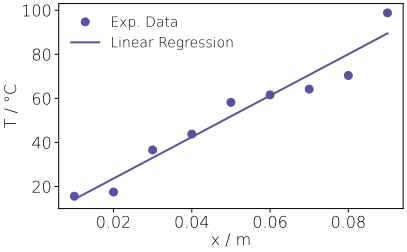

In [17]:
plt.plot(x,T, 'o', label='Exp. Data')

X_fit = np.zeros([x_fit.shape[0],2])
X_fit[:,0] = 1
X_fit[:,1] = x_fit
plt.plot(x_fit, np.dot(X_fit,W_opt), color=colors[0], label='Linear Regression' )
plt.xlabel('x / m')
plt.ylabel('T / °C')
plt.legend()

## Next Time: What do we do when we can't minimize by hand?